In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import numpy as np
from csrank.fate_choice import FATEChoiceFunction

Using TensorFlow backend.


# Learning choice functions

We apply our first-aggregate-then-evaluate (FATE) architecture to the problem of learning choice functions.
We will first start to investigate latent linear functions to sanity check our implementation.
Then we will move to the problem of learning Pareto-optimality.
## Learning a latent linear function


In [2]:
data_seed = 126
weight_seed = 35
n_train = 100000
n_test = 100000
n_features = 2
n_objects = 6
n_rep_units = 5
threshold = 1

In [3]:
from sklearn.utils import check_random_state
def make_latent_linear_choices(n_inst=10000, n_features=2, n_objects=6,
                               n_rep_units=5, threshold=0.,
                               data_seed=None, weight_seed=None):
    rand = check_random_state(data_seed)
    ranw = check_random_state(weight_seed)
    X = rand.uniform(-1, 1, size=(n_inst, n_objects, n_features))
    W_rep = ranw.randn(n_features, n_rep_units)
    rep = X.dot(W_rep).mean(axis=-2)
    w_join = ranw.randn(n_features + n_rep_units)
    joint_matrix = np.empty((n_objects, n_inst, n_features + n_rep_units),
                            dtype=np.float32)
    for i in range(n_objects):
        joint_matrix[i] = np.concatenate((X[:, i], rep), axis=-1)
    scores = joint_matrix.dot(w_join)
    Y = scores > threshold
    return X, Y.T, W_rep, w_join

In [4]:
X_train, Y_train, W_rep, w_join = make_latent_linear_choices(
    n_inst=n_train,
    n_features=n_features,
    n_objects=n_objects,
    n_rep_units=n_rep_units,
    data_seed=data_seed,
    weight_seed=weight_seed,
    threshold=threshold)
X_test, Y_test, W_rep, w_join = make_latent_linear_choices(
    n_inst=n_train,
    n_features=n_features,
    n_objects=n_objects,
    n_rep_units=n_rep_units,
    data_seed=data_seed+1,
    weight_seed=weight_seed,
    threshold=threshold)
print(Y_train.mean())

0.160225


Since we used only 2 features, we can plot the positive and negative objects of the dataset:

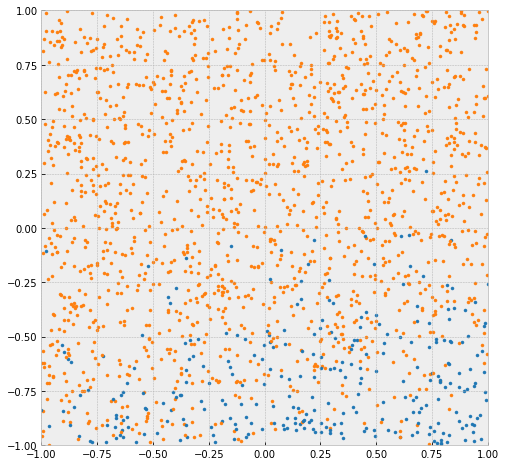

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
colors = sns.color_palette('tab10', n_colors=2)
for i, (x, y) in enumerate(zip(X_train[:300], Y_train[:300])):
    ax.scatter(x[y][:, 0], x[y][:, 1], c=[colors[0]], marker='.')
    ax.scatter(x[~y][:, 0], x[~y][:, 1], c=[colors[1]], marker='.')

In [4]:
from yellowfin import YFOptimizer
from keras.optimizers import TFOptimizer
from keras.metrics import binary_accuracy
opt = TFOptimizer(YFOptimizer(learning_rate=0.1))
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=2,
                          n_hidden_joint_units=32,
                          n_hidden_set_layers=2,
                          n_hidden_set_units=32,
                          optimizer=opt,
                          batch_size=512,
                          metrics=[binary_accuracy])

In [7]:
fate.fit(X_train, Y_train, verbose=True, epochs=50)

Train on 81000 samples, validate on 9000 samples
Epoch 1/50
81000/81000 [==============================] - 5s 56us/step - loss: 0.0942 - binary_accuracy: 0.9644 - val_loss: 0.0499 - val_binary_accuracy: 0.9767
Epoch 2/50
81000/81000 [==============================] - 3s 41us/step - loss: 0.0429 - binary_accuracy: 0.9824 - val_loss: 0.0438 - val_binary_accuracy: 0.9800
Epoch 3/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0301 - binary_accuracy: 0.9870 - val_loss: 0.0603 - val_binary_accuracy: 0.9758
Epoch 4/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0352 - binary_accuracy: 0.9851 - val_loss: 0.0201 - val_binary_accuracy: 0.9913
Epoch 5/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0293 - binary_accuracy: 0.9880 - val_loss: 0.0107 - val_binary_accuracy: 0.9970
Epoch 6/50
81000/81000 [==============================] - 3s 42us/step - loss: 0.0278 - binary_accuracy: 0.9889 - val_loss: 0.0225 - val_binary_ac

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


KeyboardInterrupt: 

In [8]:
fate.threshold

0.39622626

In [9]:
pred = fate.predict(X_test)

In [10]:
from sklearn.metrics import f1_score, accuracy_score

print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.9921
Micro F1 measure: 0.9921
Subset Accuracy: 0.9853


In [11]:
pred_threshold = fate.predict_scores(X_test) > fate.threshold

In [12]:
from sklearn.metrics import f1_score, accuracy_score

print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred_threshold, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred_threshold, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred_threshold)))

Macro F1 measure: 0.9944
Micro F1 measure: 0.9944
Subset Accuracy: 0.9896


## Learning Pareto-Optimality
We now try to solve the problem of predicting the Pareto-optimal set of points $O\subseteq X$.
In other words, it is the set of points which or not dominated by any other point.

Let us plot a small example:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import numpy as np
from csrank.fate_choice import FATEChoiceFunction

Using TensorFlow backend.


In [3]:
from sklearn.utils import check_random_state
def pareto_front(X, signs=None):
    n_points, n_attributes = X.shape
    if signs is None:
        signs = -np.ones(n_attributes)
    pareto = np.ones(n_points, dtype=bool)
    for i, attr in enumerate(X):
        pareto[i] = np.all(np.any((X*signs[None, :]) <= (attr*signs), axis=1))
    return pareto

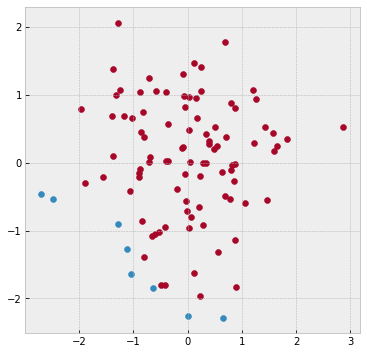

In [4]:
X = np.random.randn(100, 2)
fig, ax = plt.subplots(figsize=(6,6))
pareto = pareto_front(X)
ax.scatter(X[pareto][:, 0], X[pareto][:, 1])
ax.scatter(X[~pareto][:, 0], X[~pareto][:, 1]);

In this example we have to criteria which we want to minimize.
The blue points form the Pareto-front.

In [5]:
from sklearn.utils import check_random_state
def sample_unit_ball(n_inst=10000, n_features=2, rng=None, radius=1.):
    rng = check_random_state(rng)
    X = rng.randn(n_inst, n_features)
    u = rng.uniform(size=n_inst)[:, None]
    X /= np.linalg.norm(X, axis=1, ord=2)[:, None]
    X *= radius * u
    return X
def make_randn_pareto_choices(n_inst=10000, n_features=2, n_objects=10, data_seed=None, center=0.):
    """Generate random objects from a d-dimensional isometric normal distribution.
    
    This should be the easiest possible Pareto-problem, since the model can learn
    a latent-utility which scores how likely a point is on the front (independent
    of the other points)."""
    rand = check_random_state(data_seed)
    X = rand.randn(n_inst, n_objects, n_features)
    Y = np.empty((n_inst, n_objects), dtype=bool)
    for i in range(n_inst):
        Y[i] = pareto_front(X[i])
    return X+center, Y
def make_globular_pareto_choices(n_inst=10000, n_features=2, n_objects=10, data_seed=None,
                                 cluster_spread=1., cluster_size=10):
    rand = check_random_state(data_seed)
    X = np.empty((n_inst, n_objects, n_features))
    Y = np.empty((n_inst, n_objects), dtype=bool)
    for i in range(int(n_inst / cluster_size)):
        center = sample_unit_ball(n_inst=1, n_features=n_features,
                                  rng=rand, radius=cluster_spread)
        x, y = make_randn_pareto_choices(n_inst=cluster_size, n_features=n_features, n_objects=n_objects,
                                         data_seed=rand, center=center)
        X[i*cluster_size:(i+1)*cluster_size] = x
        Y[i*cluster_size:(i+1)*cluster_size] = y
    return X, Y

In [5]:
from csrank import SyntheticIterator
n_inst = 1024
n_objects = 30
n_features = 5
pareto_iter = SyntheticIterator(make_randn_pareto_choices,
                                n_inst=n_inst, n_features=n_features, n_objects=n_objects)

In [6]:
n_train = 10000
n_test = 10000
n_objects = 10
n_features = 2
seed = 123

X_train, Y_train = make_globular_pareto_choices(n_inst=n_train, n_objects=n_objects,
                                             n_features=n_features, data_seed=seed,
                                                cluster_spread=10)
X_test, Y_test = make_globular_pareto_choices(n_inst=n_test, n_objects=n_objects,
                                           n_features=n_features, data_seed=seed+1,
                                              cluster_spread=10)

Text(0.5,1,'Learning the Pareto-front of a given set of points')

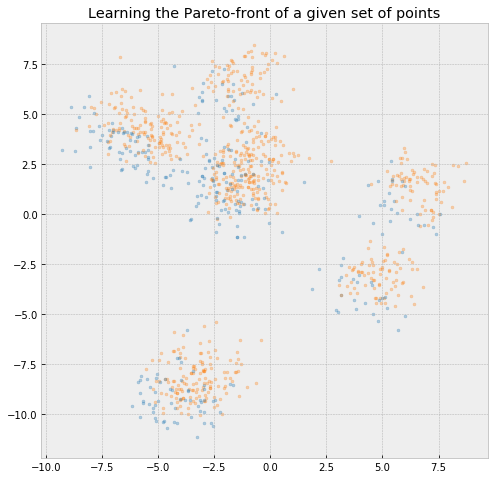

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
#ax.set_xlim(-1, 1)
#ax.set_ylim(-1, 1)
colors = sns.color_palette('tab10', n_colors=2)
for i, (x, y) in enumerate(zip(X_train[:1000], Y_train[:100])):
    ax.scatter(x[y][:, 0], x[y][:, 1], c=[colors[0]], marker='.', alpha=0.3)
    ax.scatter(x[~y][:, 0], x[~y][:, 1], c=[colors[1]], marker='.', alpha=0.3)
plt.title("Learning the Pareto-front of a given set of points")
#plt.savefig('globular.png')

(-1.5, 1.5)

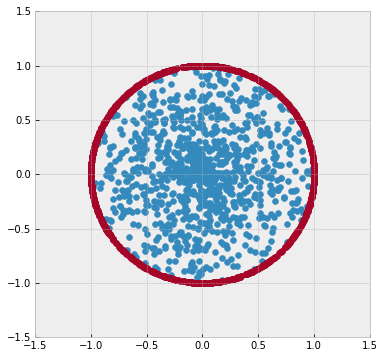

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
n = 1000
a = np.random.randn(n, 2)
u = np.random.uniform(size=n)[:, None]
b = a / np.linalg.norm(a, ord=2, axis=1)[:, None]
c = b * u
#ax.scatter(a[:, 0], a[:, 1])
ax.scatter(c[:, 0], c[:, 1])
ax.scatter(b[:, 0], b[:, 1])

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

In [14]:
import tensorflow as tf
from sklearn.utils import compute_class_weight
from sklearn.metrics import f1_score
def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.

    Here it is only computed as a batch-wise average, not globally.
    """
    return f1_score(y_true, y_pred, average='micro')

In [15]:
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.regularizers import l2
from csrank.fate_choice import FATEChoiceFunction
n_hidden_set_units = 128
n_hidden_set_layers = 3
n_hidden_joint_units = 128
n_hidden_joint_layers = 3
fate = FATEChoiceFunction(n_object_features=n_features,
                          n_hidden_joint_layers=n_hidden_joint_layers,
                          n_hidden_joint_units=n_hidden_joint_units,
                          n_hidden_set_layers=n_hidden_set_layers,
                          n_hidden_set_units=n_hidden_set_units,
                          optimizer=SGD(lr=1e-10, momentum=0.9, nesterov=True),
                          #optimizer=opt,
                          batch_size=512,
                          kernel_regularizer=l2(1e-6),
                          metrics=[binary_accuracy])

In [11]:
from csrank import ParameterOptimizer
ranges = {fate: {'n_hidden_set_units': (8, 128),
                 'n_hidden_set_layers': (1, 10),
                 'n_hidden_joint_units': (8,  128),
                 'n_hidden_joint_layers': (1, 10),
                 'reg_strength': (1e-10, 1e-2, 'log-uniform'),
                 'learning_rate': (1e-6, 1e-1, 'log-uniform'),
                 'batch_size': (32, 1024)}}
opt=ParameterOptimizer(fate, optimizer_path='./', tunable_parameter_ranges=ranges,
                   fit_params=dict(epochs=50),
                   random_state=None,
                   validation_loss=fmeasure)

In [12]:
opt.fit(X_train, Y_train)

/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


IsADirectoryError: [Errno 21] Is a directory: './'

In [60]:
from keras.callbacks import TensorBoard, LearningRateScheduler
netname = '{}-{}-{}-{}-{}d-{}o'.format(n_hidden_set_units, n_hidden_set_layers,
                               n_hidden_joint_units, n_hidden_joint_layers, n_features,
                               n_objects)
tb = TensorBoard(log_dir='/home/kiudee/git/cs-ranking/logs/{}'.format(netname))
tb.__name__ = 'TensorBoard'

def trapezoidal(epoch):
    low_lr = 1e-10
    high_lr = 1e-1
    epochs_ramp_up = 15
    epochs_explore = 60
    epochs_ramp_down = 50
    if epoch <= epochs_ramp_up:
        p = epoch / epochs_ramp_up
        return p * high_lr + (1-p) * low_lr
    elif epoch > epochs_ramp_up and epoch < epochs_explore + epochs_ramp_up:
        return high_lr
    else:
        p = (epoch - epochs_explore - epochs_ramp_up) / epochs_ramp_down
        return min(p * low_lr + (1-p) * high_lr, high_lr)
lr = LearningRateScheduler(trapezoidal)
lr.__name__ = 'LRScheduler'

In [61]:
fate.fit(X_train, Y_train, verbose=False, epochs=140, log_callbacks=[tb, lr])

In [44]:
fate.fit(X_train, Y_train, verbose=False, epochs=10, log_callbacks=[tb],
         optimizer=SGD(lr=1e-6, momentum=0.9, nesterov=True))

In [28]:
X_test, Y_test = make_randn_pareto_choices(n_inst=10000, n_objects=n_objects,
                                           n_features=n_features)

In [127]:
from sklearn.metrics import f1_score, accuracy_score
#X_test, Y_test = make_randn_pareto_choices()
pred = fate.predict(X_test)
print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.5703
Micro F1 measure: 0.5705
Subset Accuracy: 0.0938


In [43]:
from sklearn.metrics import f1_score, accuracy_score
#X_test, Y_test = make_randn_pareto_choices()
pred = fate.predict(X_test)
print('Macro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='macro')))
print('Micro F1 measure: {:.4f}'.format(f1_score(Y_test, pred, average='micro')))
print('Subset Accuracy: {:.4f}'.format(accuracy_score(Y_test, pred)))

Macro F1 measure: 0.0000
Micro F1 measure: 0.0000
Subset Accuracy: 0.0000


/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kiudee/anaconda3/envs/gpflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
